# Case study with mixed images using the FICA implementation

In [42]:
#using Pkg
#Pkg.add("ImageView")
using Images, FileIO, Colors

## Loading the test images and converting them to a grayscale image
For this case study we used 2 cat pictures, they will be refered to as cat one and cat two by
order of appearance

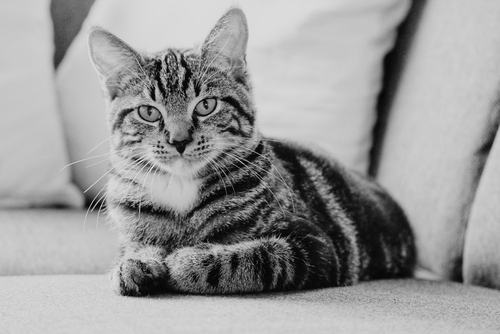

In [43]:
cat_one = load("cat_one_resize.jpg")
cat_oneg = Gray.(cat_one)

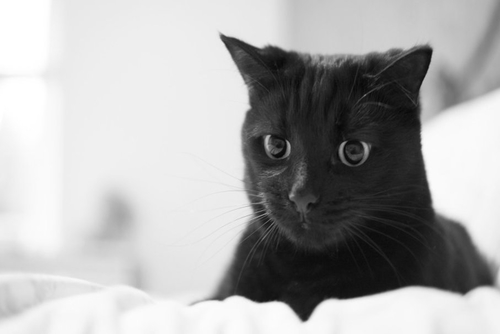

In [44]:
cat_two = load("cat_two_resize.jpg")
cat_twog = Gray.(cat_two)

## Mixing the images together to create 2 mixed images
For each image we use a different factor ( array A )
the first mixed image has a stronger presence from cat two and the second image a stronger presence from cat one

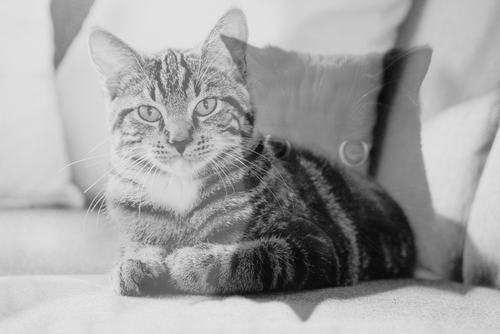

In [45]:
using LinearAlgebra
#convert image to array
mat_one = convert(Array{Float64},cat_oneg);
mat_two = convert(Array{Float64},cat_twog);
#get rows and column to later reconstruct the mixed image
rows,col = size(mat_one)
#convert 2D images to 1D (vector)
vec_one = vec(mat_one)';
vec_two = vec(mat_two)';

S = vcat(vec_one , vec_two)';

#generate first mixed signal
#factor used for the image
#A = [0.2 , 0.8] 
A = [0.6 , 0.4] 

X = (S .* A')'

X = X[1,:,]+X[2,:,]

imageX = reshape(X,rows,col)
img = colorview(Gray, imageX)

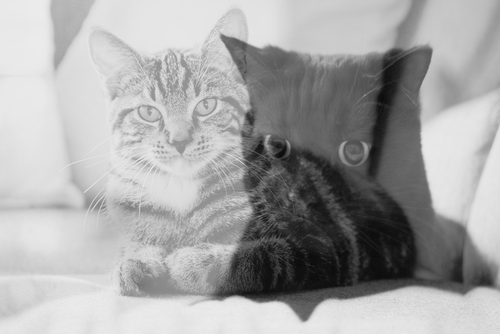

In [46]:
#generate second mixed signal
#factor used for the image
#A = [0.8 , 0.2] 
A = [0.4 , 0.6] 
Z = (S .* A')'

Z = Z[1,:,]+Z[2,:,]
mixed_signal = hcat(X,Z);
imageZ = reshape(Z,rows,col)
img = colorview(Gray,imageZ)



## Applying the FICA algorithm

In [227]:
include("fastICA.jl")

#forced weights
wei = [0.86456941 1.0646533 ; 0.07053282 0.8470662]

W = fastICA.whiten(mixed_signal)
X1 = mixed_signal * W'
#direct call to deflation function to pass weights
#a = fastICA.fast_ica_def(200,2,Array(X1'),0.0001,wei, 1.)
#a = fastICA.fast_ica(200,2,Array(X1'),0.0001, 1.)
K = a * W
S = K * mixed_signal';

## Results

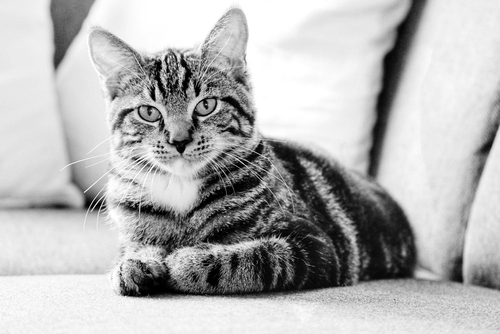

In [228]:
firstres = reshape(S[1,:,]+S[2,:,],rows,col)
scale = scaleminmax(round(Int8,minimum(firstres)),round(Int8,maximum(firstres)))
img = colorview(Gray, scale.(firstres))

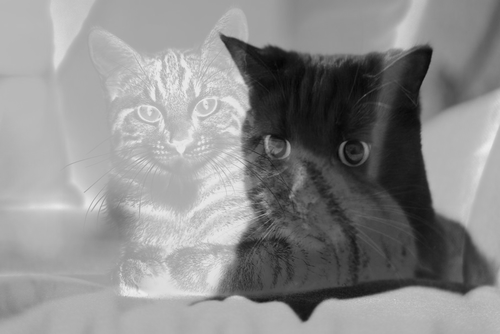

In [229]:
secondres = reshape(S[1,:,]-S[2,:,],rows,col)
scale = scaleminmax(round(Int8,minimum(secondres)),round(Int8,maximum(secondres)))
img = colorview(Gray, scale.(secondres))

In [118]:
function mserror(A,B,width,height) sum = 0.0
    for x = 1:width
       for y = 1:height
          difference = (A[x,y] - B[x,y])
          sum = sum + difference*difference
        end
    end
    mse = sum /(width*height)
    println("The mean square error is $mse")
end          

mserror (generic function with 1 method)

In [131]:
mserror(cat_oneg,firstres,rows,col)

The mean square error is 2.289494889326831


In [130]:
mserror(cat_twog,secondres,rows,col)

The mean square error is 10.512875584854278


In [9]:
X1

167000×2 Array{Float64,2}:
 3.611    -0.757514
 3.61886  -0.772787
 3.61886  -0.772787
 3.61886  -0.772787
 3.62673  -0.78806 
 3.62673  -0.78806 
 3.63459  -0.803334
 3.63459  -0.803334
 3.62673  -0.78806 
 3.62673  -0.78806 
 3.62673  -0.78806 
 3.61886  -0.772787
 3.61886  -0.772787
 ⋮                 
 3.34192  -0.504662
 3.3655   -0.550482
 3.35764  -0.535208
 3.33406  -0.489388
 3.3655   -0.550482
 3.24759  -0.321382
 3.21615  -0.260289
 3.35764  -0.535208
 3.38908  -0.596301
 3.40464  -0.65107 
 3.37336  -0.565755
 3.31817  -0.483064

In [230]:
using Statistics 

maxiter = 200
nic = 2 
tol = 0.001
W = wei
X = Array(X1')
alpha = 1.0
retW = zeros(size(W))
wp = 0
wx= 0
#src : http://www.measurement.sk/2011/Patil.pdf pg 119 
      for i = 1:nic
            wp = W[i,:,]            
            #to-do create aux func
            if (i > 1)
                t = zeros(size(wp))
                for u = 1:(i-1)
                   k = sum(wp .* retW[u,:,])
                   t = t + k * retW[u,:,]
                end
                wp = wp - t 
            end
            normalize!(wp)
            iter = 0
            chg = 0
            converge = false
            while !converge && iter < maxiter
                iter+=1
                wx = wp' * X
                gdx,gddx = contrast_func(alpha,wx)
                xgdx = X .* gdx
                v1 = vec(mapslices(mean, xgdx, dims = 2))
                v2 = mean(gddx) * wp
                w1 = v1 - v2
                #to-do create aux func
                if (i > 1) 
                    t = zeros(size(w1))
                    for u = 1:(i-1)
                        k = sum(w1 .* retW[u,:,])
                        t = t + k * retW[u,:,]
                    end
                    w1 = w1 - t
                    println("wp=$wp")
                end
                normalize!(w1)
                #check for convergence
                chg =  abs.(abs.(sum(w1 .* wp)) .- 1.0)
                wp = w1
                converge = ( chg < tol )
            end
            retW[i,:,] = wp
            println(retW)
        end

[0.95562 -0.294602; 0.0 0.0]
wp=[0.294602, 0.95562]
[0.95562 -0.294602; -0.294602 -0.95562]


In [216]:
using LinearAlgebra
tanh.(alpha * a)


2×2 Array{Float64,2}:
 0.761594  0.964028
 0.995055  0.999329